In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.fft import fft
from scipy.fft import ifft
from scipy.signal import get_window
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt



In [2]:
# Define the high-pass filter
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs  # Nyquist Frequency
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

# Apply the filter to a signal
def highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def ac_components(data, mode, cutoff, fs):
    if mode == 'mean':
       #Calculate DC components (mean values) for ax, ay, and az
       dc = data.mean()
       # Calculate AC components by subtracting DC component from each signal
       ac = data - dc
       return ac
    elif mode == 'jerk':
       #other paper calculated AC components via jerk (change in subsequent measurements)
       #ac = data.diff().fillna(0)
       ac = np.diff(data, n=1, prepend=data[:1])  # Prepend the first element to keep the array size consistent

       return ac
    elif mode == 'HP':
        ac = highpass_filter(data, cutoff, fs)
        return ac
    else:
        raise ValueError(f"Invalid mode: {mode}")

In [3]:
def parse_acc_data(row):
    # Split the string by commas and convert to integers
    acc_values = np.array(row.split(',')).astype(int)
    # Reshape the array to (-1, 3) assuming the pattern ax, ay, az continuously
    reshaped_values = acc_values.reshape(-1, 3)
    # Return separate lists for ax, ay, az
    return reshaped_values[:, 0], reshaped_values[:, 1], reshaped_values[:, 2]


In [4]:
def process_new_format(filepath):
    filepath = '../datasets/Fredrik_funny_walk.csv'
    data = pd.read_csv(filepath, dtype={'label': str}, na_values='null', low_memory=False)
    column_names = ['unknown1', 'unknown2', 'tag_id', 'unknown3', 'unknown4', 'lat', 'long', 'timestamp', 'unknown5', 'acc_data']
    data.columns = column_names
    data[['ax', 'ay', 'az']] = pd.DataFrame(data['acc_data'].apply(parse_acc_data).tolist(), index=data.index)
    return data

In [14]:
def import_and_downsample(filepath, plot, mode, categories=None, tagdata=False):
    if tagdata == True:
        data = process_new_format(filepath)
        filtered_data = data[['ax', 'ay', 'az']].copy()
        
    else:  
        data = pd.read_csv(filepath, dtype={'label': str}, na_values='null', low_memory=False) #change nulls to NaN
        data = data.dropna(subset=['label']) #Drop NaN rows (undefined / other behavior)
        # Filter the DataFrame
        data= data[data['label'].isin(categories)] 
        filtered_data = data[['ax', 'ay', 'az', 'label', 'animal_ID', 'timestamp_ms']]
        data25 = filtered_data.iloc[::4, :].copy() #downsample 100Hz data to 25Hz data

        # Calculate window index for each sample
        # 10 second windows and conversion from ms to s
        data25['window_index'] = data25['timestamp_ms'] // 10000

        # Group data by window_index, and then split into individual windows
        windows = [window for _, window in data25.groupby('window_index')]

        #data25.to_csv('datasets/filtered_data_25hz.csv', index=False)
        del data, filtered_data #no longer need the huge data sets, free up memory to make it run faster
    

    #test plot first window(s)
    if plot ==True:
        # Determine the number of samples per window (10 seconds * 25 Hz)
        samples_per_window = 10 * 25
        total_windows = len(data25) // samples_per_window
        
        for axis in ['ax', 'ay', 'az']:
            for window in range(total_windows):
                if window == 0:
                    start_idx = window * samples_per_window
                    end_idx = start_idx + samples_per_window
                    data_window = data25.iloc[start_idx:end_idx]
                    plt.figure(figsize=(10, 4))
                    plt.plot(data_window['timestamp_ms'] / 1000, data_window[axis], label=axis)
                    
                    # Adding title and labels
                    plt.title(f'{axis.upper()} Time Signal Window {window + 1}')
                    plt.xlabel('Time (s)')
                    plt.ylabel('Acceleration (g)')
                    plt.legend()
                    plt.tight_layout()
                    plt.show()
                    
                    
                    
    fs = 10.0       # sample rate, Hz
    cutoff = 0.3    # desired cutoff frequency of the filter, Hz
    windows_ac = []

    if tagdata == False:
        #mode = 'HP'     # choose 'HP', 'mean' or 'jerk'
        min_length = 18
        if tagdata == False:
            for window in windows:
                if len(window['ax']) >= min_length:
                    window['ac_ax'] = ac_components(window['ax'], mode, cutoff, fs)
                    window['ac_ay'] = ac_components(window['ay'], mode, cutoff, fs)
                    window['ac_az'] = ac_components(window['az'], mode, cutoff, fs)
                    windows_ac.append(window)
            
                    #plotting both AC variants to see difference
        if plot ==True:
            plt.figure(figsize=(15, 6))
            plt.plot(windows_ac[0]['timestamp_ms'] / 1000, windows_ac[0]['ax'], label='Original ax')
            plt.plot(windows_ac[0]['timestamp_ms'] / 1000, windows_ac[0]['ac_ax'], label='AC component of ax', linestyle='--')
            plt.title('Original and AC Component of ax Over Time')
            plt.xlabel('Time (s)')
            plt.ylabel('Acceleration (g)')
            plt.legend()
            plt.show()


            plt.figure(figsize=(15, 6))
            plt.plot(windows_ac[0]['timestamp_ms'] / 1000, windows_ac[0]['ax'], label='Original ax')
            plt.plot(windows_ac[0]['timestamp_ms'] / 1000, windows_ac[0]['jerk_ax'], label='Jerk component of ax', linestyle='--')
            plt.title('Original and AC Component of ax Over Time')
            plt.xlabel('Time (s)')
            plt.ylabel('Acceleration (g)')
            plt.legend()
            plt.show()       
       
    else:
        filtered_data['ac_ax'] = filtered_data['ax'].apply(lambda x: ac_components(np.array(x), mode, cutoff, fs))
        filtered_data['ac_ay'] = filtered_data['ay'].apply(lambda x: ac_components(np.array(x), mode, cutoff, fs))
        filtered_data['ac_az'] = filtered_data['az'].apply(lambda x: ac_components(np.array(x), mode, cutoff, fs))
        
    if tagdata:
        windows_ac = [filtered_data.iloc[[i]].copy() for i in range(len(filtered_data))]
    return windows_ac




1. Divide the AC component into 1-second windows: Since your data is sampled at 25 Hz, a 1-second window will contain 25 samples.

2. Apply the Hanning window function: This is a windowing function used to reduce the spectral leakage before performing the FFT.

3. Compute the FFT for each window: Perform the FFT on each windowed segment of the AC component.

4. Handle 50% overlap: When moving to the next window, you start at the halfway point of the current window, which means each window will overlap the previous one by 50%.

In [44]:
def process_window(windows_ac, windowID=None, tagdata=False):
    sampling_rate = 25  # 25 Hz sampling rate
    if tagdata:
        sampling_rate = 6
    window_size = sampling_rate  # 1-second window for 1 Hz resolution
    overlap = window_size // 2  # 50% overlap
    hann_window = get_window('hann', window_size)
    
    # Initialize structure to store time domain signals
    all_time_domain_signals = {}
    
    # Determine which windows and axes to process
    axes_to_process = ['ax'] if windowID is not None else ['ax', 'ay', 'az']
    window_indices = [windowID] if windowID is not None else range(len(windows_ac))
    
    for axis in axes_to_process:
        all_time_domain_signals[axis] = {}
        
        for ID in window_indices:
            # Initialize frequency bands for the current window and axis
            all_time_domain_signals[axis][ID] = {f: [] for f in range(6)}
            
            # Adapted data access based on `tagdata`
            if tagdata:
                # Directly access the array/list of values
                window_data = windows_ac[ID][axis]
            else:
                # Convert from a DataFrame or similar structure
                window_data = windows_ac[ID][f'ac_{axis}'].to_numpy()
            
            for i in range(0, len(window_data) - window_size + 1, overlap):
                window_segment = window_data[i:i+window_size] * hann_window
                fft_result = fft(window_segment, n=window_size)
                
                for f in range(6):
                    isolated_fft = np.zeros_like(fft_result)
                    isolated_fft[f] = fft_result[f]
                    time_signal = ifft(isolated_fft, n=window_size).real
                    all_time_domain_signals[axis][ID][f].append(time_signal[:window_size])

            # Concatenate overlapping windows for each frequency band
            for f in all_time_domain_signals[axis][ID]:
                if all_time_domain_signals[axis][ID][f]:  # Check if the list is not empty
                    concatenated_signal = [all_time_domain_signals[axis][ID][f][0]]
                    for segment in all_time_domain_signals[axis][ID][f][1:]:
                        concatenated_signal.append(segment[overlap:])
                    all_time_domain_signals[axis][ID][f] = np.concatenate(concatenated_signal)

            if windowID is not None and axis == 'ax':
                # Plot only for the X-axis if windowID is provided
                plot_signals(all_time_domain_signals[axis][windowID], windowID, axis)
    
    # If no specific windowID is provided, all_time_domain_signals contains all axes for all windows
    return all_time_domain_signals
def plot_signals(time_domain_signals, windowID, axis):
    time_vector = np.linspace(0, 10, num=len(time_domain_signals[0]), endpoint=False)
    plt.figure(figsize=(15, 6))
    for f in range(6):
        plt.plot(time_vector + 10*windowID, time_domain_signals[f], label=f'{f} Hz Band')
    plt.title(f'Spectral Components for {axis.upper()} ({windowID*10} to {windowID*10 + 10} seconds)')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (g)')
    plt.legend()
    plt.show()
        # subplots,  one for each frequency band
    num_bands = 6
    fig, axes = plt.subplots(num_bands, 1, figsize=(15, 2*num_bands))
    time_vector = np.linspace(0, 10, num=len(time_domain_signals[0]), endpoint=False)
    for f in range(num_bands):
        ax = axes[f] if num_bands > 1 else axes
        ax.plot(time_vector + windowID*10, time_domain_signals[f], label=f'{f} Hz Band')  
        ax.set_title(f'Frequency Band {f} Hz')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude (g)')
        ax.legend()
    plt.tight_layout()
    plt.show()
    

In [47]:
hmmge = import_and_downsample('../datasets/Fredrik_funny_walk.csv', False, 'HP', None, True)
test = process_window(hmmge, None, True)
test

{'ax': {0: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
  1: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
  2: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
  3: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
  4: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
  5: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
  6: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
  7: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
  8: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
  9: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
  10: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
  11: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
  12: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
  13: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
  14: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
  15: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
  16: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
  17: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
  18: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
  19: {0: [], 1: [], 2: [], 3: [], 4: [], 5: []},
  20

In [33]:
categories = ['walking', 'standing', 'grazing', 'eating']
hmmge2 = import_and_downsample('../datasets/pos_A.csv', False, 'HP', categories, False)
#test2 = process_window(import_and_downsample('../datasets/pos_A.csv', False, 'HP', categories, False))
hmmge2[1]['ac_ax']

1000   -0.022265
1004    1.655526
1008   -0.374915
1012    0.021726
1016   -0.155343
          ...   
1980    3.747206
1984    0.059774
1988   -0.190486
1992   -1.233781
1996   -0.250973
Name: ac_ax, Length: 250, dtype: float64

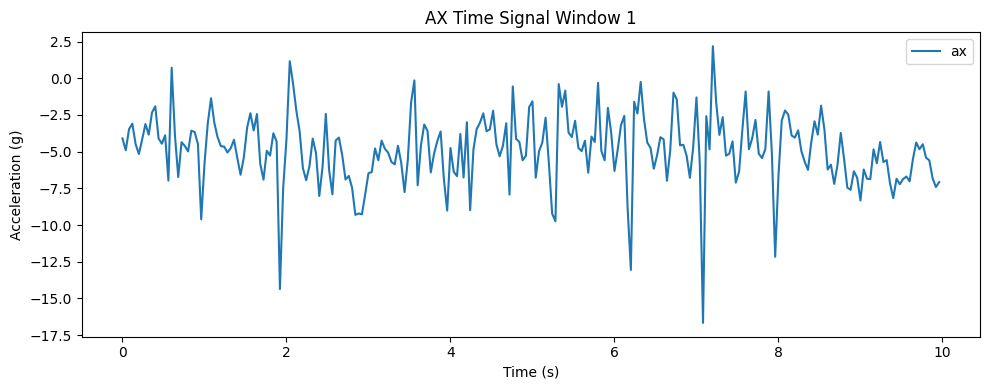

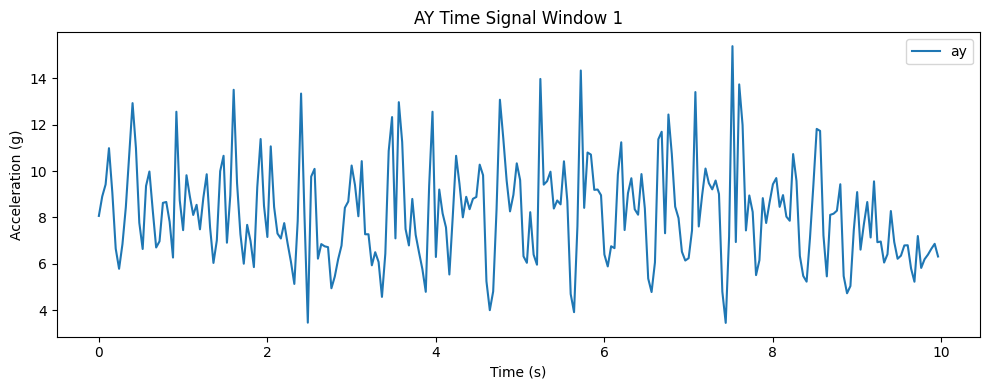

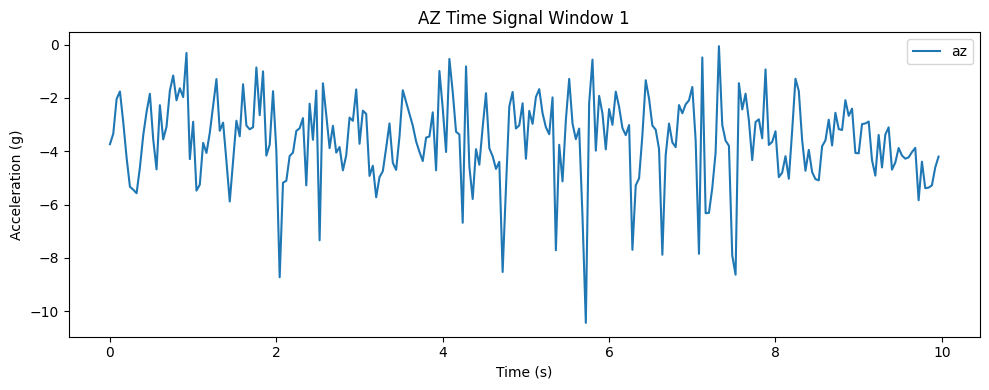

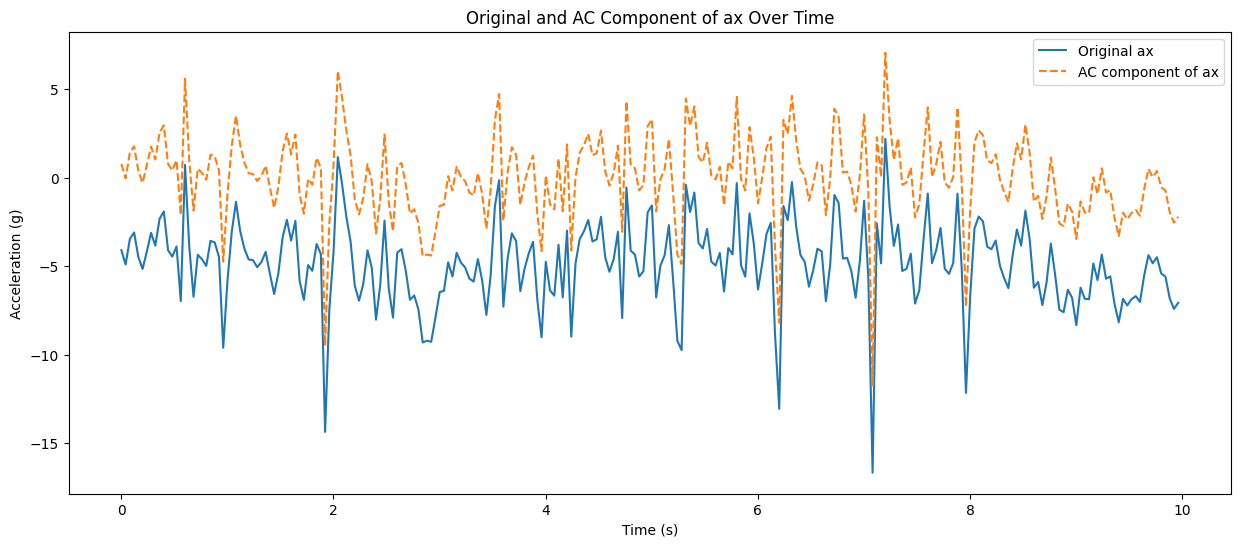

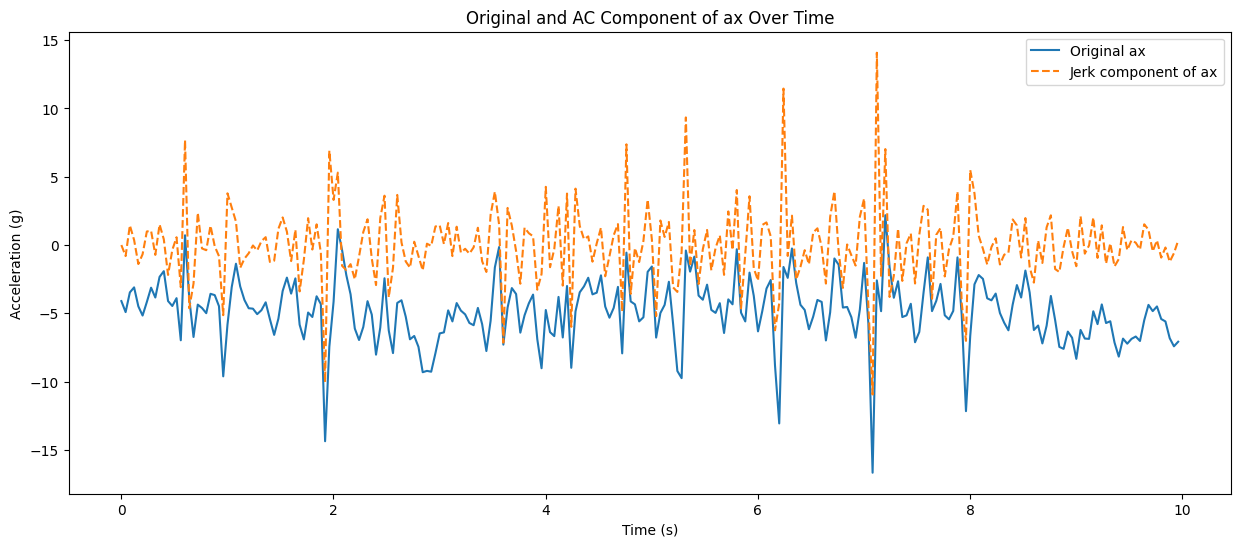

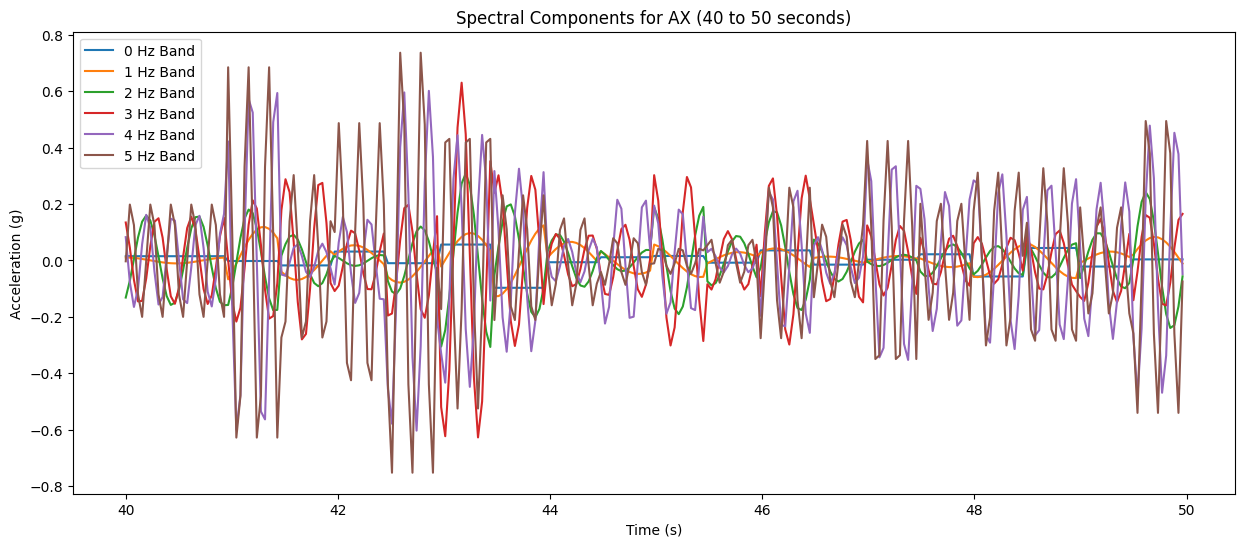

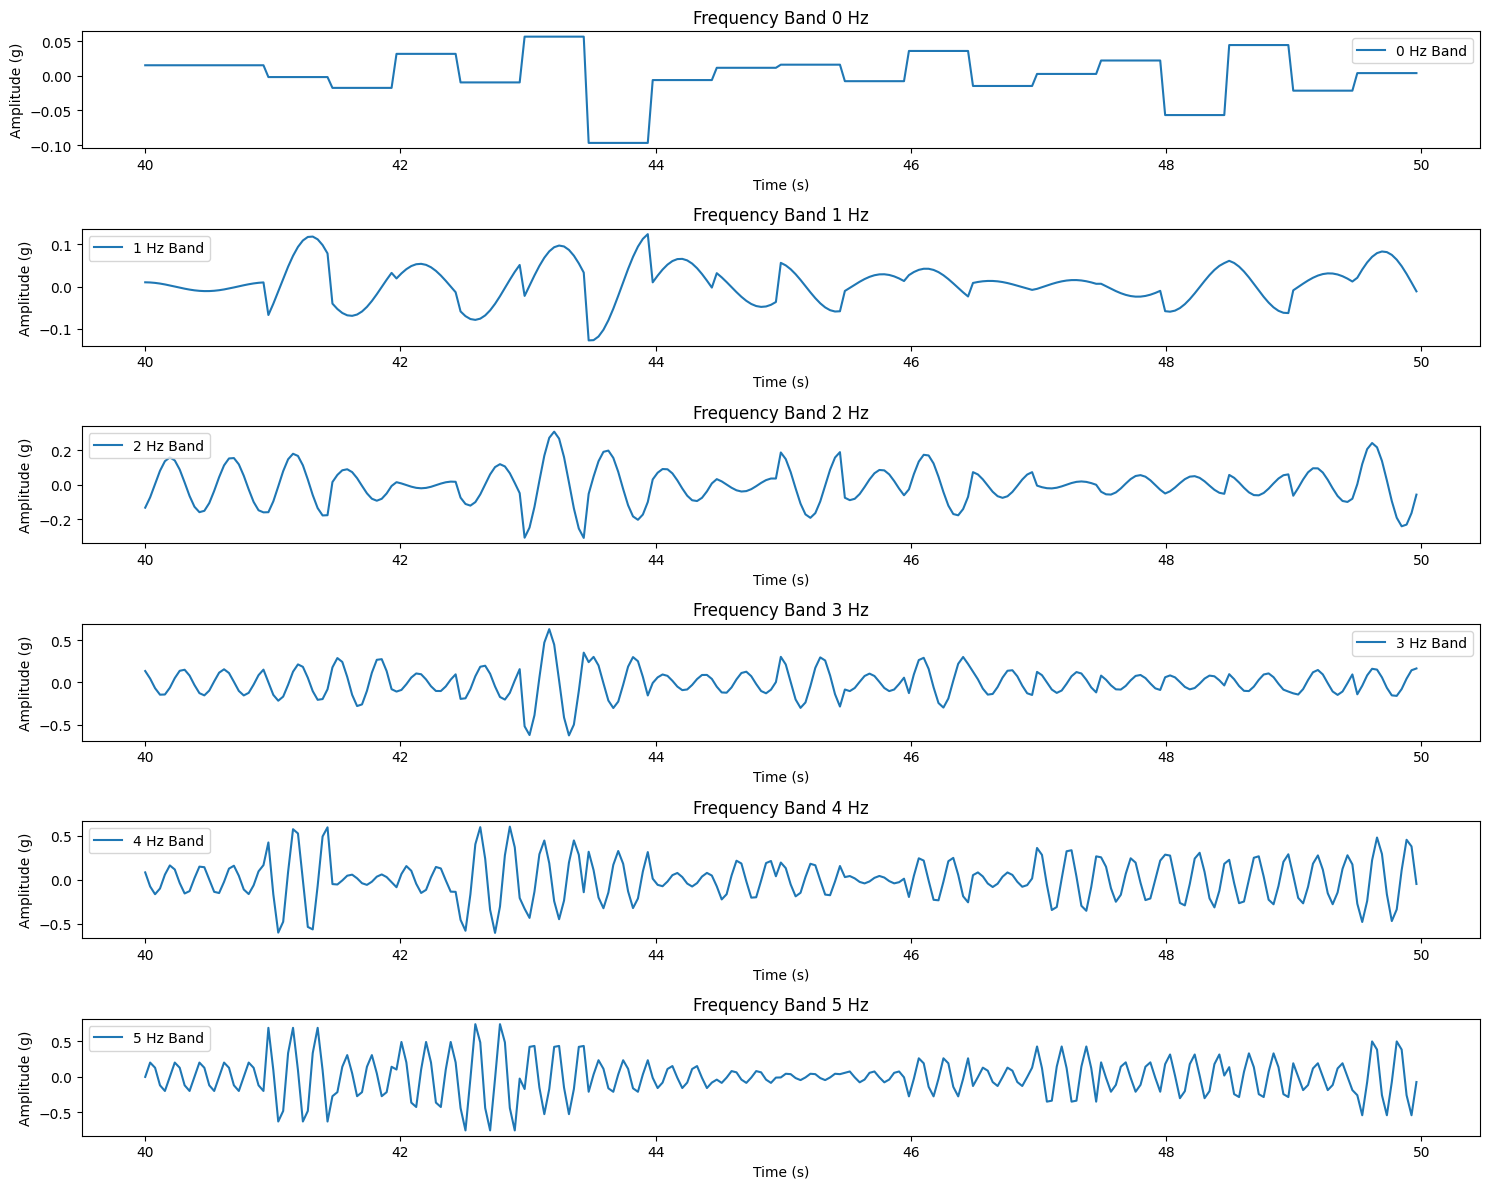

In [20]:
filepath = 'datasets/pos_A.csv'
windows_ac = import_and_downsample(filepath, plot=True) #

windowID = 4 # Set to None to process all windows, or to a specific ID to process just that window and plot (for the x-axis)

if windowID is not None:
    process_window(windows_ac, windowID) 
else:
    all_time_domain_signals = process_window(windows_ac)